# Analysis workflow of the pacbio 2019 alzheimer Sequel2 dataset

## Preparation
1) prepare the working directory and download the reference and data
``` bash
    cd /my/working/directory
    # create some subdirectories
    mkdir -p reference isoseq/flnc isoseq/aligned isoseq/pickle tables plots
    
    # download a reference genome (806 MB)
    genome_link='ftp://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_29/GRCh38.primary_assembly.genome.fa.gz'
    wget -P reference/ -O GRCh38_genome_primary_assembly_gencode_v29.fa.gz ${genome_link} 
    gunzip reference/GRCh38_genome_primary_assembly_gencode_v29.fa.gz
    
    
    # download gencode reference annotation (46.2 MB)
    annotation_link='ftp://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_29/gencode.v29.annotation.gff3.gz'
    wget -P reference/ -O gencode_v29_annotation.gff3.gz ${annotation_link} 
    gff='reference/gencode_v29_annotation'
    # sort by chromosome and position
    (zcat ${gff}.gff3.gz| grep ^"#" ; zcat ${gff}.gff3.gz|grep -v ^"#"| sort -k1,1 -k4,4n)|bgzip  > ${gff}_sorted.gff3.gz
    # create index
    tabix -p gff ${gff}_sorted.gff3.gz
    
    # download the isoseq flnc data (4.1 GB)
    isoseq_link='https://downloads.pacbcloud.com/public/dataset/Alzheimer2019_IsoSeq/FullLengthReads/flnc.bam'
    wget -P isoseq/flnc -O alzheimer2019_isoseq_flnc.bam ${isoseq_link} 
```

2) align the isoseq data to the reference genome using minimap2.
If the pacbio isoseq3 workflow is [installed](https://github.com/PacificBiosciences/IsoSeq_SA3nUP/wiki/Tutorial:-Installing-and-Running-Iso-Seq-3-using-Conda) you can use the pacbio version of minimap2 as follows:

``` sh
    #activate the isoseq3 environement (assuming it is called pacbio)
    conda activate pacbio
    n_threads=60
    sample='alzheimer2019_isoseq'
    ref='reference/GRCh38_genome_primary_assembly_gencode_v29.fa'
    pbmm2 align ${ref} isoseq/flnc/${sample}_flnc.bam isoseq/aligned/${sample}_aligned.sorted.bam --preset ISOSEQ --sort -j $n_threads 
```



## Isotools workflow

In [1]:
from  isotools.transcriptome import Transcriptome
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


In [2]:
sample='alzheimer2019_isoseq'
path='/project/42/pacbio/bin/isotools/examples' #adapt to your working directory
bam=f'{path}/isoseq/aligned/{sample}_aligned.sorted.bam'
genome=path+'/reference/GRCh38_genome_primary_assembly_gencode_v29.fa'
anno=path+'/reference/gencode_v29_annotation_sorted'



In [3]:
try:
    #try to restore previously prepared data
    isoseq=Transcriptome(f'{path}/isoseq/pickle/{sample}_isotoolsXXX.pkl')
except FileNotFoundError:
    #import the reference (2-3 minutes)
    isoseq=Transcriptome.from_reference(anno+'.gff3.gz') 
    # save the reference, so it it can be restored for other analysis
    isoseq.save_reference(anno+'.isotools.pkl') 
    # import the long read data and compare to reference (only one sample for this dataset, takes 30-40 minutes)
    isoseq.add_sample_from_bam(bam, sample_name='alzheimer_1', group='alzheimer') 
    # compute QC metrics for all transcripts
    isoseq.add_biases(genome) #takes 15-20 min
    # update the index for fast gene access by name/id
    isoseq.make_index()
    # save the current data
    isoseq.save(f'{path}/isoseq/pickle/{sample}_isotools.pkl')


2739373it [02:22, 19183.77it/s]
 97%|█████████▋| 4261038.0/4411279 [31:42<01:07, 2239.67transcripts/s, chr=KI270757.1]
100%|██████████| 281576/281576 [16:10<00:00, 290.22it/s] 


In [4]:
#access of genes by Name
print(isoseq['MAPT'])

Gene MAPT chr17:45894381-46028334(+), 18 reference transcripts, 267 expressed transcripts


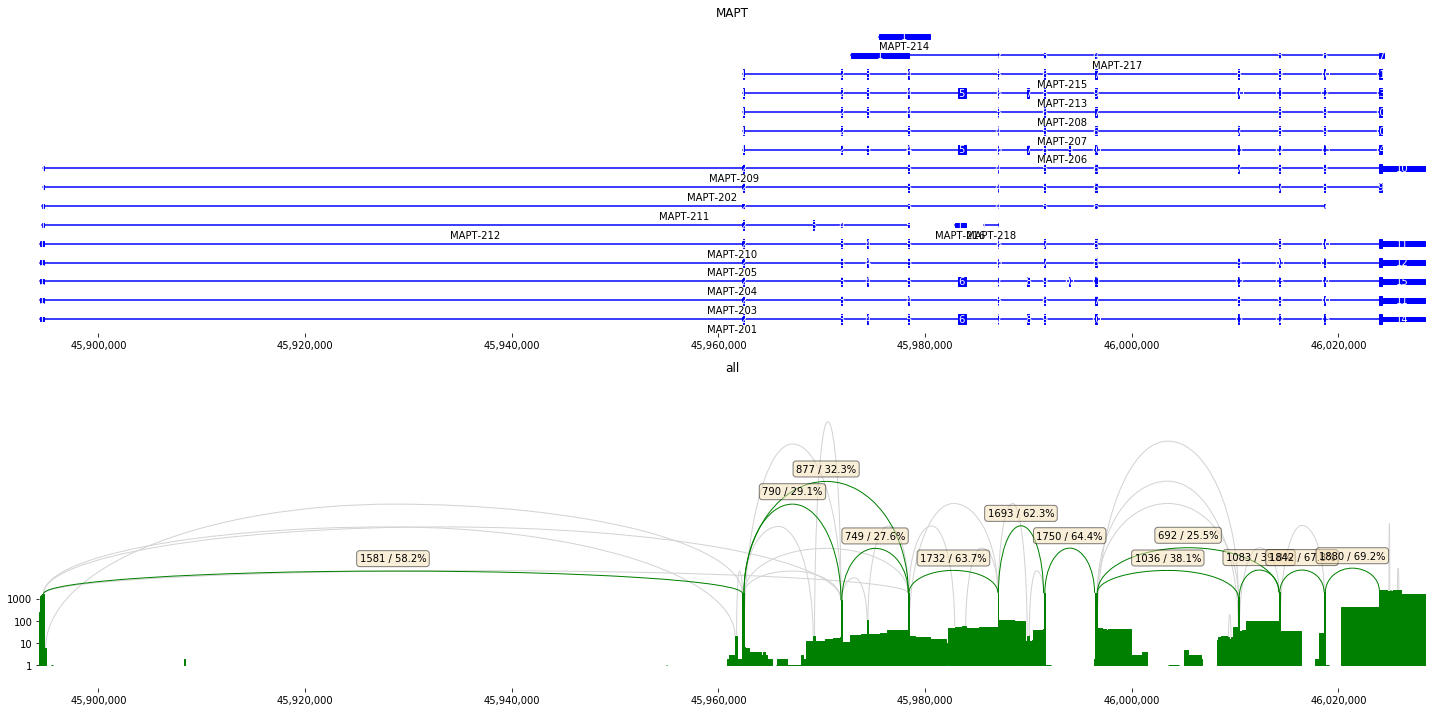

In [5]:
plt.rcParams["figure.figsize"] = (20,10)
fig,axs=isoseq['MAPT'].sashimi_plot()
#for ax in axs:
#    ax.set_xlim(45960000,46025000)
fig.tight_layout()